In [1]:
import time
from spade.agent import Agent
from spade.behaviour import CyclicBehaviour, PeriodicBehaviour, OneShotBehaviour, FSMBehaviour, State
from spade.message import Message
from spade.template import Template
import json
import asyncio
from random import random
from copy import deepcopy

In [2]:
from datetime import datetime

today = datetime.today()
print("Today's date:", today)

Today's date: 2022-06-12 13:09:31.262250


In [3]:
today

datetime.datetime(2022, 6, 12, 13, 9, 31, 262250)

In [4]:
password="Secret777"

In [5]:
jid ="SystemAgent@jabbim.pl"

In [6]:
class MachineAgent(Agent):

    def __init__(self, jid, password, verify_security, inputs, outputs, production_time, chance_to_break, magazine, item_prices, euro, up_price, down_price, providers, maintainers, stock):
        self.inputs=inputs
        self.outputs=outputs
        self.production_time=production_time
        self.chance_to_break=chance_to_break
        self.magazine=magazine
        self.item_prices=item_prices
        self.euro=euro
        self.up_price=up_price
        self.down_price=down_price
        self.providers=providers
        self.maintainers=maintainers
        self.stock=stock
        self.needed={item:self.inputs[item]-self.magazine[item] for item in self.inputs if self.magazine[item]<self.inputs[item]}
        self.start_production=True
        self.working_status=True
        
        super().__init__(jid, password, verify_security=verify_security)

    class ProduceBehav(CyclicBehaviour):
        async def run(self):
            await asyncio.sleep(1)
            self.agent.needed={item:self.agent.inputs[item]-self.agent.magazine[item] for item in self.agent.inputs if self.agent.magazine[item]<self.agent.inputs[item]}
            if(random()<self.agent.chance_to_break or self.agent.working_status==False):
                if self.agent.working_status:
                    print("broken")

                self.agent.working_status=False
                for maintainer in self.agent.maintainers:
                    msg = Message(to=maintainer)
                    msg.set_metadata("repair", "request")
                    await self.send(msg)
                    print("can you repair me?")
                    msg = await self.receive(timeout=10)
                    if msg:
                        if msg.get_metadata("repair")=="accepted":
                            print("waiting for repair")     
                            msg = await self.receive(timeout=10)
                            if msg:
                                if msg.get_metadata("repair")=="machine":
                                    self.agent.working_status=True
                                    print("Thank you for repair")
                                    break
                    else:
                        print("answer not received")

            if self.agent.start_production and self.agent.working_status and len(self.agent.needed)==0:
                await asyncio.sleep(self.agent.production_time)
                for item in self.agent.inputs:
                    self.agent.magazine[item]=self.agent.magazine[item]-self.agent.inputs[item]
                for item in self.agent.outputs:
                    self.agent.magazine[item]=self.agent.magazine[item]+self.agent.outputs[item]

                self.agent.stock.notify(str(self.agent.jid),datetime.today(),self.agent.magazine)

    class BuyBehav(CyclicBehaviour):

        async def run(self):
            propositions_list=[]
            if len(self.agent.needed)>0:
                for item in self.agent.needed:
                    for Provider in self.agent.providers[item]:
                        msg = Message(to=Provider)
                        msg.set_metadata("buy", "order")
                        msg.body = json.dumps({"item": item,"quantity":str(self.agent.needed[item])})
                        await self.send(msg)
                        print(Provider+" please "+item)
                        
                    
                    while len(propositions_list)<len(self.agent.providers[item]):
                        msg = await self.receive(timeout=10)
                        propositions_list.append(msg)
                    
                    best_price=100000
                    best_proposition=None
                    for msg in propositions_list:
                        if msg:
                            if msg.get_metadata("sell")=="proposition":
                                print("Message received with content: {}".format(msg.body))
                                body = json.loads(msg.body)
                                get_item = body["item"]
                                get_payment = int(body["payment"])
                                if get_payment<best_price:
                                    best_proposition=msg
                                    best_price=get_payment
                                
                    if best_proposition:
                        msg = Message(to=str(best_proposition.sender))
                        msg.set_metadata("buy", "payment")
                        if item in self.agent.needed.keys() and self.agent.euro>=best_price:
                            msg.body = json.dumps({"item": item, "quantity":str(self.agent.needed[item]),"payment":str(best_price)})
                            self.agent.euro-=best_price
                            await self.send(msg)
                            print("sending cash")
                            
                            msg = await self.receive(timeout=10)
                            if msg:
                                if msg.get_metadata("sell")=="product":
                                    body = json.loads(msg.body)
                                    get_item = body["item"]
                                    get_quantity = int(body["quantity"])

                                    self.agent.magazine[item]=self.agent.magazine[item]+get_quantity
                                    self.agent.stock.notify(str(self.agent.jid),datetime.today(),self.agent.magazine)
                                    print("thank you " + str(best_proposition.sender))   

            

    class SellBehav(CyclicBehaviour):
        async def run(self):
            #await asyncio.sleep(1)
            msg = await self.receive(timeout=10)
            if msg:
                get_type=msg.get_metadata("buy")
                body = json.loads(msg.body)
                get_item = body["item"]
                get_quantity = int(body["quantity"])
                if get_type=="order":
                    if self.agent.magazine[get_item]>=get_quantity:
                        msg = Message(to=str(msg.sender))
                        msg.set_metadata("sell", "proposition")
                        #update price
                        print("Changing price from "+str(self.agent.item_prices[get_item])+" to "+str(int(self.agent.item_prices[get_item]*self.agent.down_price)))
                        self.agent.item_prices[get_item]=int(self.agent.item_prices[get_item]*self.agent.down_price)
                        
                        msg.body = json.dumps({"item": get_item,"payment":str(self.agent.item_prices[get_item]*get_quantity)})
                        await self.send(msg)
                        print("proposing")
                    else:
                        msg = Message(to=str(msg.sender))
                        msg.set_metadata("sell", "decline")
                        msg.body = json.dumps({"item": get_item, "quantity":0})
                        await self.send(msg)
                        print("no item now")
                        self.agent.start_production=True
                        
                if get_type=="payment":
                    get_payment = int(body["payment"])                    
                    self.agent.euro+=get_payment
                    self.agent.magazine[get_item]=self.agent.magazine[get_item]-get_quantity
                    self.agent.stock.notify(str(self.agent.jid),datetime.today(),self.agent.magazine)
                    msg = Message(to=str(msg.sender))
                    msg.set_metadata("sell", "product")
                    msg.body = json.dumps({"item": get_item,"quantity":str(get_quantity)})
                    
                    #update price
                    print("up price")
                    self.agent.item_prices[get_item]=int(self.agent.item_prices[get_item]*self.agent.up_price)
                    
                    await self.send(msg)
                    print("sending product")
                    
            else:
                print("waiting for sell")

    async def setup(self):
        print(f"MachineAgent started at {datetime.now().time()}")
        t_repair = Template()
        t_repair.set_metadata("repair", "machine")
        t_repair_decline = Template()
        t_repair_decline.set_metadata("repair", "declined")
        t_repair_accepted = Template()
        t_repair_accepted.set_metadata("repair", "accepted")
        t_product = Template()
        t_product.set_metadata("sell", "product")
        t_decline = Template()
        t_decline.set_metadata("sell", "decline")
        t_proposition = Template()
        t_proposition.set_metadata("sell", "proposition")
        t_order = Template()
        t_order.set_metadata("buy", "order")
        t_payment = Template()
        t_payment.set_metadata("buy", "payment")
        self.p = self.ProduceBehav()
        self.add_behaviour(self.p,t_repair | t_repair_decline | t_repair_accepted)
        self.b = self.BuyBehav()
        self.add_behaviour(self.b,t_product | t_decline | t_proposition)
        self.s = self.SellBehav()
        self.add_behaviour(self.s,t_payment | t_order)
        await asyncio.sleep(5)

In [7]:
class OrderAgent(Agent):

    def __init__(self, jid: str, password: str, verify_security: bool, need, magazine, request_time, max_item_price, providers, stock):
        self.need=need
        self.providers=providers
        self.magazine=magazine
        self.request_time=request_time
        self.max_item_price=max_item_price
        self.stock=stock
        super().__init__(jid, password, verify_security=verify_security)

    class GetBehav(CyclicBehaviour):
        async def run(self):
            
            await asyncio.sleep(self.agent.request_time)
            item=self.agent.need
            propositions_list=[]
            for Provider in self.agent.providers[item]:
                msg = Message(to=Provider)
                msg.set_metadata("buy", "order")
                msg.body = json.dumps({"item": item,"quantity":1})
                await self.send(msg)
                print(Provider+" please "+item)


            while len(propositions_list)<len(self.agent.providers[item]):
                msg = await self.receive(timeout=10)
                propositions_list.append(msg)


            best_price=100000
            best_proposition=None
            for msg in propositions_list:
                if msg:
                    if msg.get_metadata("sell")=="proposition":
                        print("Message received with content: {}".format(msg.body))
                        body = json.loads(msg.body)
                        get_item = body["item"]
                        get_payment = int(body["payment"])
                        if get_payment<best_price and get_payment<=self.agent.max_item_price:
                            best_proposition=msg
                            best_price=get_payment

            if best_proposition:
                msg = Message(to=str(best_proposition.sender))
                msg.set_metadata("buy", "payment")
                msg.body = json.dumps({"item": item, "quantity":1,"payment":str(best_price)})
                await self.send(msg)
                print("sending cash "+str(best_price))
                msg = await self.receive(timeout=10)
                if msg:
                    body = json.loads(msg.body)
                    get_item = body["item"]
                    get_quantity = int(body["quantity"])
                    self.agent.magazine[item]=self.agent.magazine[item]+get_quantity
                    self.agent.stock.notify(str(self.agent.jid),datetime.today(),self.agent.magazine)
                    print("thank you " + str(best_proposition.sender))


    async def setup(self):
        print(f"OrderAgent started at {datetime.now().time()}")
        t_product = Template()
        t_product.set_metadata("sell", "product")
        t_decline = Template()
        t_decline.set_metadata("sell", "decline")
        t_proposition = Template()
        t_proposition.set_metadata("sell", "proposition")
        self.b = self.GetBehav()
        self.add_behaviour(self.b,t_product | t_decline | t_proposition)
        await asyncio.sleep(5)

In [60]:
class MaintenanceAgent(Agent):
    def __init__(self, jid: str, password: str, verify_security: bool, repair_time):
        self.repair_time=repair_time
        self.busy=False
        self.client=None
        super().__init__(jid, password, verify_security=verify_security)
    

    class RepairBehav(CyclicBehaviour):
        async def run(self):
            await asyncio.sleep(1)
            #print(self.agent.client)
            if self.agent.busy and self.agent.client!=None:
                await asyncio.sleep(self.agent.repair_time)
                msg = Message(to=self.agent.client)
                msg.set_metadata("repair", "machine")
                print("Repairing "+self.agent.client)
                await self.send(msg)
                self.agent.busy=False

    class ListenBehav(CyclicBehaviour):
        async def run(self):
            await asyncio.sleep(1)
            msg = await self.receive(timeout=10)
            if msg:
                if msg.get_metadata("repair") and self.agent.busy==False:
                    print("repair accepted")
                    self.agent.client=str(msg.sender)
                    msg = Message(to=str(msg.sender))
                    msg.set_metadata("repair", "accepted")
                    await self.send(msg)
                    self.agent.busy=True
                else:
                    msg = Message(to=str(msg.sender))
                    msg.set_metadata("repair", "declined")
                    await self.send(msg)

    async def setup(self):
        print(f"MaintenanceAgent started at {datetime.now().time()}")
        t_repair = Template()
        t_repair.set_metadata("repair", "request")
        self.l = self.ListenBehav()
        self.add_behaviour(self.l,t_repair)
        self.r = self.RepairBehav()
        self.add_behaviour(self.r)

In [9]:
class Stock():

    def __init__(self,agent_magazines):
        self.agent_magazines=agent_magazines

    def notify(self,agent,timestamp,magazine):
        self.agent_magazines[agent].append((timestamp,deepcopy(magazine)))
        

In [34]:
import dash
from dash import dcc, html
import plotly
from dash.dependencies import Input, Output
from random import randrange
import pandas as pd

In [53]:
import plotly.express as px
import pandas as pd

In [37]:
data=factory.Stock.agent_magazines

flat=[]
for a in data:
    for r in data[a]:
        time=r[0]
        for p in r[1]:
            flat.append({"time":time,"product":p,"quantity":r[1][p],"agent":a})

df=pd.DataFrame(flat)

In [46]:
df=pd.DataFrame(flat)

In [58]:
px.line(df,x="time",y="quantity",color="agent")

ValueError: Invalid color agent

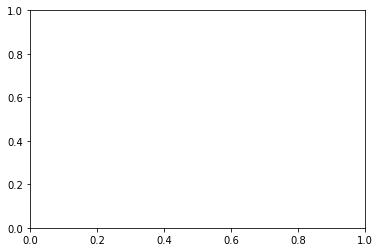

In [52]:
df.plot(x="time",y="quantity",color="agent")

In [41]:
data2=data["systemagent@jabbim.pl/2"]

In [36]:
factory.Stock.agent_magazines

{'systemagent@jabbim.pl/2': [(datetime.datetime(2022, 6, 12, 13, 19, 58, 799551),
   {'milk': 1}),
  (datetime.datetime(2022, 6, 12, 13, 19, 58, 911500), {'milk': 0}),
  (datetime.datetime(2022, 6, 12, 13, 20, 0, 799698), {'milk': 1}),
  (datetime.datetime(2022, 6, 12, 13, 20, 0, 961505), {'milk': 0}),
  (datetime.datetime(2022, 6, 12, 13, 20, 2, 799835), {'milk': 1}),
  (datetime.datetime(2022, 6, 12, 13, 20, 2, 926988), {'milk': 0}),
  (datetime.datetime(2022, 6, 12, 13, 20, 4, 799955), {'milk': 1}),
  (datetime.datetime(2022, 6, 12, 13, 20, 4, 973872), {'milk': 0}),
  (datetime.datetime(2022, 6, 12, 13, 20, 6, 800096), {'milk': 1}),
  (datetime.datetime(2022, 6, 12, 13, 20, 6, 942050), {'milk': 0}),
  (datetime.datetime(2022, 6, 12, 13, 20, 8, 800232), {'milk': 1}),
  (datetime.datetime(2022, 6, 12, 13, 20, 8, 986271), {'milk': 0}),
  (datetime.datetime(2022, 6, 12, 13, 20, 10, 800387), {'milk': 1}),
  (datetime.datetime(2022, 6, 12, 13, 20, 10, 992523), {'milk': 0}),
  (datetime.da

In [11]:
es = ['https://codepen.io/chriddyp/pen/bWLwgP.css']

app = dash.Dash(__name__, external_stylesheets=es)
app.layout = html.Div(
    html.Div([
        html.H4('Factory UI'),
        #html.H5('Items in Magazine'),
        html.H5(id='live-update-text'),
        #html.Div(id='live-update-text'),
        dcc.Graph(id='live-update-graph'),
        dcc.Interval(
            id='interval-component',
            interval=1*1000, # in milliseconds
            n_intervals=0
        )
    ])
)

@app.callback(Output('live-update-text', 'children'),
              Input('interval-component', 'n_intervals'))
def update_metrics(n):
    #agent_magazines = satellite.get_lonlatalt(datetime.datetime.now())
    #lists2 = stock.agent_magazines["systemagent@jabbim.pl/2"]
    #print(itemz)
    data = {
        'name': [],
        'money': [],
    }
    for m in factory.machine_list:
        data['name'].append(str(m.jid))
        data['money'].append(str(m.euro))
    #agent1euro = str(agent2.euro)
    style = {'padding': '5px'}
    return [
       html.Span(data['name'], style=style),   
       #html.Span(data['money'], style=style),
       html.Div([
        #html.Span(data['name'], style=style),   
        html.Span(data['money'], style=style)
       ])     
    ]
    # k=[]
    # for values in lists2.items():
    #     for i in values:
    #       k.append(i) 
  
    #return agent2.euro

@app.callback(Output('live-update-graph', 'figure'),
              Input('interval-component', 'n_intervals'))
def update_graph_live(n):
    x = []
    y = []

    product_list =[product for product in factory.Providers]

    k=next(iter(factory.Stock.agent_magazines))
    for element in factory.Stock.agent_magazines.get(k):
    print(res)
        for value in element[1].items():
            y.append(value)
 
 
    # Create the graph with subplots
    fig = plotly.tools.make_subplots(rows=3, cols=1, vertical_spacing=0.1)
    fig['layout']['margin'] = {
                'l': 40, 'r': 10, 'b': 20, 't': 10
            }
    fig['layout']['legend'] = {'x': 0, 'y': 1, 'xanchor': 'left'}
            
    fig.append_trace({
        'x': x,
        'y': y,
        'name': 'milk',
        'mode': 'lines+markers',
        'type': 'scatter',
    }, 1, 1)         
  


    fig.update_xaxes(title_text="time", row=1, col=1)
    fig.update_yaxes(title_text="Items Count", row=1, col=1)

    fig.update_layout(title_text="Items in magazine", height=2000,width=1200)


    return fig

In [32]:
product_list =[product for product in factory.Providers]

In [33]:
product_list

['milk']

In [16]:
factory.Stock.agent_magazines

{'systemagent@jabbim.pl/2': [(datetime.datetime(2022, 6, 12, 13, 12, 4, 492372),
   {'milk': 1}),
  (datetime.datetime(2022, 6, 12, 13, 12, 4, 527016), {'milk': 0}),
  (datetime.datetime(2022, 6, 12, 13, 12, 6, 492525), {'milk': 1}),
  (datetime.datetime(2022, 6, 12, 13, 12, 6, 535098), {'milk': 0}),
  (datetime.datetime(2022, 6, 12, 13, 12, 8, 492671), {'milk': 1}),
  (datetime.datetime(2022, 6, 12, 13, 12, 8, 542913), {'milk': 0}),
  (datetime.datetime(2022, 6, 12, 13, 12, 10, 492914), {'milk': 1}),
  (datetime.datetime(2022, 6, 12, 13, 12, 10, 551341), {'milk': 0}),
  (datetime.datetime(2022, 6, 12, 13, 12, 12, 493661), {'milk': 1}),
  (datetime.datetime(2022, 6, 12, 13, 12, 12, 496480), {'milk': 0}),
  (datetime.datetime(2022, 6, 12, 13, 12, 14, 493867), {'milk': 1}),
  (datetime.datetime(2022, 6, 12, 13, 12, 14, 607739), {'milk': 0}),
  (datetime.datetime(2022, 6, 12, 13, 12, 16, 494027), {'milk': 1}),
  (datetime.datetime(2022, 6, 12, 13, 12, 16, 632085), {'milk': 0}),
  (datetim

In [19]:
class Factory():
    def __init__(self,jid,password):
        self.jid=jid
        self.password=password
        self.max_id=0
        
    def load_agents(self,factory_setting):
        with open(factory_setting) as json_file:
            data = json.load(json_file)
        json_file.close()
        
        maintainer_list=[]
        for ma in data["Maintainers"]:
            for i in range(ma["number"]):
                self.max_id+=1
                maintainer_list.append(MaintenanceAgent(self.jid+"/"+str(self.max_id), self.password, False, ma["repair_time"]))
        
        machine_list=[]
        for m in data["Machines"]:
            for i in range(m["number"]):
                self.max_id+=1
                machine_list.append(MachineAgent(self.jid+"/"+str(self.max_id), self.password, False, m["inputs"],m["outputs"],m["production_time"],m["chance_to_break"],deepcopy(m["magazine"]),deepcopy(m["item_prices"]),m["euro"],m["up_price"],m["down_price"],None,maintainer_list,None))
        
        Providers={}
        
        for m in machine_list:
            for p in m.outputs:
                if p in Providers:
                    Providers[p].append(str(m.jid))
                else:
                    Providers[p]=[str(m.jid)]
                
        for m in machine_list:
            m.providers={p:Providers[p] for p in m.inputs if p in Providers}
        
        order_list=[]
        for o in data["Orders"]:
            for i in range(o["number"]):
                self.max_id+=1
                order_list.append(OrderAgent(self.jid+"/"+str(self.max_id), self.password, False, o["need"], deepcopy(o["magazine"]), o["request_time"],o["max_item_price"], None, None))

        for order in order_list:
            order.providers={p:Providers[p] for p in [order.need] if p in Providers}
            
        stock=Stock({str(m.jid):[] for m in machine_list+order_list})
        for m in machine_list+order_list:
            m.stock=stock
            
        self.Stock=stock
        self.Providers=Providers
        self.maintainer_list=maintainer_list
        self.machine_list=machine_list
        self.order_list=order_list
        
    def run_agents(self,timeout=30):
        
        try:
            for ma in self.maintainer_list:
                ma.start()
                
            for m in self.machine_list:
                m.start()
            
            for o in self.order_list:
                o.start()
            app.run(use_reloader=False,debug=True)
            time.sleep(timeout)
        except Exception as e:
            print(e)
        finally:
            print("STOPPING!")
            for ag in self.maintainer_list+self.machine_list+self.order_list:
                ag.stop()          

In [20]:
factory=Factory(jid,password)

In [21]:
factory.load_agents('Factory1.json')

In [22]:
factory.run_agents()

Dash is running on http://127.0.0.1:8050/

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on
MaintenanceAgent started at 13:19:51.689686
OrderAgent started at 13:19:51.699226
MachineAgent started at 13:19:51.797984
MachineAgent started at 13:19:51.828323
OrderAgent started at 13:19:51.904003
OrderAgent started at 13:19:51.948319
systemagent@jabbim.pl/2 please milk
systemagent@jabbim.pl/3 please milk
no item now
no item now
systemagent@jabbim.pl/2 please milk
systemagent@jabbim.pl/3 please milk
no item now
no item now
systemagent@jabbim.pl/2 please milk
systemagent@jabbim.pl/3 please milk
no item now
no item now
systemagent@jabbim.pl/2 please milk
systemagent@jabbim.pl/3 please milk
no item now
no item now
systemagent@jabbim.pl/2 please milk
systemagent@jabbim.pl/3 please milk
Changing price from 400 to 360
proposing
Changing price from 400 to 360
proposing
Message received with content: {"item": "milk", 

systemagent@jabbim.pl/2 please milk
systemagent@jabbim.pl/3 please milk
no item now
no item now
systemagent@jabbim.pl/2 please milk
systemagent@jabbim.pl/3 please milk
no item now
no item now
systemagent@jabbim.pl/2 please milk
systemagent@jabbim.pl/3 please milk
no item now
no item now
systemagent@jabbim.pl/2 please milk
systemagent@jabbim.pl/3 please milk
no item now
no item now
systemagent@jabbim.pl/2 please milk
systemagent@jabbim.pl/3 please milk
Changing price from 476 to 428
proposing
Changing price from 475 to 427
proposing
Message received with content: {"item": "milk", "payment": "428"}
Message received with content: {"item": "milk", "payment": "427"}
sending cash 427
up price
sending product
thank you systemagent@jabbim.pl/3
systemagent@jabbim.pl/2 please milk
systemagent@jabbim.pl/3 please milk
Changing price from 428 to 385
proposing
no item now
Message received with content: {"item": "milk", "payment": "385"}
sending cash 385
up price
sending product
thank you systemagent

systemagent@jabbim.pl/2 please milk
systemagent@jabbim.pl/3 please milk
no item now
no item now
systemagent@jabbim.pl/2 please milk
systemagent@jabbim.pl/3 please milk
no item now
no item now
systemagent@jabbim.pl/2 please milk
systemagent@jabbim.pl/3 please milk
no item now
no item now
systemagent@jabbim.pl/2 please milk
systemagent@jabbim.pl/3 please milk
Changing price from 570 to 513
proposing
Changing price from 566 to 509
proposing
Message received with content: {"item": "milk", "payment": "513"}
Message received with content: {"item": "milk", "payment": "509"}
systemagent@jabbim.pl/2 please milk
systemagent@jabbim.pl/3 please milk
Changing price from 513 to 461
proposing
Changing price from 509 to 458
proposing
Message received with content: {"item": "milk", "payment": "461"}
Message received with content: {"item": "milk", "payment": "458"}
sending cash 458
up price
sending product
thank you systemagent@jabbim.pl/3
systemagent@jabbim.pl/2 please milk
systemagent@jabbim.pl/3 plea

systemagent@jabbim.pl/2 please milk
systemagent@jabbim.pl/3 please milk
no item now
no item now
systemagent@jabbim.pl/2 please milk
systemagent@jabbim.pl/3 please milk
no item now
no item now
systemagent@jabbim.pl/2 please milk
systemagent@jabbim.pl/3 please milk
no item now
no item now
systemagent@jabbim.pl/2 please milk
systemagent@jabbim.pl/3 please milk
Changing price from 549 to 494
proposing
Changing price from 544 to 489
proposing
Message received with content: {"item": "milk", "payment": "494"}
Message received with content: {"item": "milk", "payment": "489"}
sending cash 489
up price
sending product
thank you systemagent@jabbim.pl/3
systemagent@jabbim.pl/2 please milk
systemagent@jabbim.pl/3 please milk
Changing price from 494 to 444
proposing
no item now
Message received with content: {"item": "milk", "payment": "444"}
sending cash 444
up price
sending product
thank you systemagent@jabbim.pl/2
systemagent@jabbim.pl/2 please milk
systemagent@jabbim.pl/3 please milk
no item now

systemagent@jabbim.pl/2 please milk
systemagent@jabbim.pl/3 please milk
no item now
no item now
systemagent@jabbim.pl/2 please milk
systemagent@jabbim.pl/3 please milk
no item now
no item now
systemagent@jabbim.pl/2 please milk
systemagent@jabbim.pl/3 please milk
no item now
no item now
systemagent@jabbim.pl/2 please milk
systemagent@jabbim.pl/3 please milk
Changing price from 528 to 475
proposing
Changing price from 525 to 472
proposing
Message received with content: {"item": "milk", "payment": "475"}
Message received with content: {"item": "milk", "payment": "472"}
sending cash 472
up price
sending product
thank you systemagent@jabbim.pl/3
systemagent@jabbim.pl/2 please milk
systemagent@jabbim.pl/3 please milk
Changing price from 475 to 427
proposing
no item now
Message received with content: {"item": "milk", "payment": "427"}
sending cash 427
up price
sending product
thank you systemagent@jabbim.pl/2
systemagent@jabbim.pl/2 please milk
systemagent@jabbim.pl/3 please milk
no item now

KeyboardInterrupt: 

In [23]:
[m.euro for m in factory.machine_list]

[14467, 14380]

In [24]:
[m.magazine for m in factory.machine_list]

[{'milk': 1}, {'milk': 2}]

In [25]:
[m.magazine for m in factory.order_list]

[{'milk': 25}, {'milk': 31}, {'milk': 11}]

In [26]:
[m.providers for m in factory.machine_list]

[{'milk': ['systemagent@jabbim.pl/2', 'systemagent@jabbim.pl/3']},
 {'milk': ['systemagent@jabbim.pl/2', 'systemagent@jabbim.pl/3']}]

In [27]:
factory.Stock.agent_magazines

{'systemagent@jabbim.pl/2': [(datetime.datetime(2022, 6, 12, 13, 19, 58, 799551),
   {'milk': 1}),
  (datetime.datetime(2022, 6, 12, 13, 19, 58, 911500), {'milk': 0}),
  (datetime.datetime(2022, 6, 12, 13, 20, 0, 799698), {'milk': 1}),
  (datetime.datetime(2022, 6, 12, 13, 20, 0, 961505), {'milk': 0}),
  (datetime.datetime(2022, 6, 12, 13, 20, 2, 799835), {'milk': 1}),
  (datetime.datetime(2022, 6, 12, 13, 20, 2, 926988), {'milk': 0}),
  (datetime.datetime(2022, 6, 12, 13, 20, 4, 799955), {'milk': 1}),
  (datetime.datetime(2022, 6, 12, 13, 20, 4, 973872), {'milk': 0}),
  (datetime.datetime(2022, 6, 12, 13, 20, 6, 800096), {'milk': 1}),
  (datetime.datetime(2022, 6, 12, 13, 20, 6, 942050), {'milk': 0}),
  (datetime.datetime(2022, 6, 12, 13, 20, 8, 800232), {'milk': 1}),
  (datetime.datetime(2022, 6, 12, 13, 20, 8, 986271), {'milk': 0}),
  (datetime.datetime(2022, 6, 12, 13, 20, 10, 800387), {'milk': 1}),
  (datetime.datetime(2022, 6, 12, 13, 20, 10, 992523), {'milk': 0}),
  (datetime.da